In [77]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
#### 분석 데이터 불러오기 

with open('res_pp_acs.pkl', 'rb') as file:
    res_pp_acs = pickle.load(file)
    
with open('res_pp_ast.pkl', 'rb') as file:
    res_pp_ast = pickle.load(file)
    
with open('res_pp_trs.pkl', 'rb') as file:
    res_pp_trs = pickle.load(file)
    
with open('res_clustering.pkl', 'rb') as file:
    res_clustering = pickle.load(file)
    
with open('res_ast.pkl', 'rb') as file:
    res_ast = pickle.load(file)

### 거래 회전율 - trade_change

In [79]:
#### Monthly_sum : 월 말 개인 별 자산 소유액

need_col = ['CASH_AST','AST_EVAL']
res_pp_ast_need_col = [col for col in res_pp_ast.columns if any(keyword in col for keyword in need_col)]
res_pp_acs_tradechange_rate = res_pp_ast[res_pp_ast_need_col]
new_columns = ['trade_change_' + col[-2:] for col in res_pp_acs_tradechange_rate.columns]
res_pp_acs_tradechange_rate.columns = new_columns
monthly_sum = res_pp_acs_tradechange_rate.groupby(res_pp_acs_tradechange_rate.columns, axis=1).sum()

#### Monthly_trade_sum : 매 달 개인 별 거래액

need_col = ['BUY_AMT','SEL_AMT']
res_pp_act_need_col = [col for col in res_pp_trs.columns if any(keyword in col for keyword in need_col)]
res_pp_acs_tradechange = res_pp_trs[res_pp_act_need_col]
new_columns = ['trade_change_' + col[-4:-2] for col in res_pp_acs_tradechange.columns]
res_pp_acs_tradechange.columns = new_columns
monthly_trade_sum = res_pp_acs_tradechange.groupby(res_pp_acs_tradechange.columns, axis=1).sum()

In [80]:
trade_change = monthly_trade_sum / monthly_sum
trade_change

,trade_change_M1,trade_change_M2,trade_change_M3,trade_change_M4
0,3.312259,3.397735,3.430515,1.731304
1,1.391809,0.799787,0.902995,1.249108
2,6.434077,6.425186,2.943391,3.704892
3,8.524159,6.165963,1.905034,9.289834
4,3.936576,4.039226,4.053565,4.026666
...,...,...,...,...
803303,2.557834,1.941885,2.121238,2.435659
803304,0.654459,0.293468,0.407042,0.640693
803305,0.380717,0.250227,0.796150,0.574792
803306,0.860285,0.850090,1.147241,0.943809


### 복권성향주식에 대한 거래 - final_score

In [81]:
return_data = pd.read_csv("final_data.csv",index_col=None)
return_data = return_data[['Instrument','1 Month Total Return' ,'Date_period']]

In [82]:
#### IVOL을 구하기 위해 Benchmark 수익률 계산 (MSCI World 지수 활용)

# 주어진 월말 종가 데이터
closing_prices = [2720.80, 2602.70, 2785.00, 2714.60, 2791.40]

# 월간 수익률 계산
monthly_returns = []
for i in range(1, len(closing_prices)):
    previous_month_close = closing_prices[i - 1]
    current_month_close = closing_prices[i]
    monthly_return = (current_month_close - previous_month_close) / previous_month_close *100
    monthly_returns.append(monthly_return)

return_data['market_return'] = [monthly_returns[0] if period == 'M1' else
                       monthly_returns[1] if period == 'M2' else
                       monthly_returns[2] if period == 'M3' else
                       monthly_returns[3] for period in return_data['Date_period']]

#거래일 데이터 추가함
return_data['trading_date'] = [20 if period == 'M1' else
                       21 if period == 'M2' else
                       20 if period == 'M3' else
                       23 for period in return_data['Date_period']]

In [83]:
#### filtered_df 로만 regression 돌리기 - regression 분석을 할 때 결측치가 포함되면 분석 결과가 정확하게 나오지 않아 제외하고 진행함 

filtered_df = return_data[return_data['1 Month Total Return'].notna()]
filtered_df_plus = return_data[return_data['1 Month Total Return'].isna()]

In [84]:
#### IVOL을 위한 Regression

X = filtered_df['market_return']
X = sm.add_constant(X)  # 상수항 a를 위해 상수열을 추가합니다.
y = filtered_df['1 Month Total Return']
model = sm.OLS(y, X).fit()

# 회귀 모델의 계수 확인
a = model.params['const']
beta = model.params['market_return']

# IVOL 계산
filtered_df['e'] = y - (a + beta * filtered_df['market_return'])

<ipython-input-84-0a5c2526a3f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['e'] = y - (a + beta * filtered_df['market_return'])


In [85]:
#### SKEW 값 

#SKEW에서 R은 조정수익률로 '1 Month Total Return' 에서 'market_return'빼야함
filtered_df['adjust_return'] = filtered_df['1 Month Total Return'] - filtered_df['market_return']
n = filtered_df['trading_date']
filtered_df['skew'] = (n*((n-1)**(3/2))*((filtered_df['adjust_return']/100**3)*n)) / ((n-1)*(n-2)*(((filtered_df['adjust_return']/100)**2)*n)**(3/2))


#### 종목 별 최종 LIDX 계산을 위한 값 도출 
filtered_df_plus[['e', 'trading_date', 'adjust_return', 'skew']] = np.nan
final = pd.concat([filtered_df, filtered_df_plus], ignore_index=True) 

<ipython-input-85-a3d067ead2f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['adjust_return'] = filtered_df['1 Month Total Return'] - filtered_df['market_return']
<ipython-input-85-a3d067ead2f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['skew'] = (n*((n-1)**(3/2))*((filtered_df['adjust_return']/100**3)*n)) / ((n-1)*(n-2)*(((filtered_df['adjust_return']/100)**2)*n)**(3/2))
<ipython-input-85-a3d067ead2f2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [86]:
#### Rank를 정하기 위해 dataframe의 빈칸은 평균값으로 대체함
final_score_data = final[['Instrument', 'Date_period','1 Month Total Return','e', 'skew']]
final_score_data = final_score_data.fillna(final_score_data.mean())

<ipython-input-86-b0c77286375f>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  final_score_data = final_score_data.fillna(final_score_data.mean())


In [87]:
#### LIDX Score 도출 

# Return rank
final_score_data['return_Rank'] = final_score_data.groupby('Date_period')['1 Month Total Return'].rank(method='first',ascending=False)
final_score_data['return_Group'] = pd.qcut(final_score_data['return_Rank'], q=20, labels=False)
final_score_data['return_Score'] = 21 - final_score_data['return_Group']

# IVOL rank
final_score_data['e_Rank'] = final_score_data.groupby('Date_period')['e'].rank(method='first',ascending=True)
final_score_data['e_Group'] = pd.qcut(final_score_data['e_Rank'], q=20, labels=False)
final_score_data['e_Score'] = 21 - final_score_data['e_Group']

#skew rank
final_score_data['skew_Rank'] = final_score_data.groupby('Date_period')['skew'].rank(method='first',ascending=True)
final_score_data['skew_Group'] = pd.qcut(final_score_data['skew_Rank'], q=20, labels=False)
final_score_data['skew_Score'] = 21 - final_score_data['skew_Group']

#LIDX Score 도출 
final_score = final_score_data[['Instrument', 'Date_period','return_Score','e_Score', 'skew_Score']]
final_score['Score'] = final_score['return_Score'] + final_score['e_Score'] + final_score['skew_Score']
final_score['LIDX'] = (final_score['Score'] - 3) / (60-3)
final_score

<ipython-input-87-59d266927d29>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_score['Score'] = final_score['return_Score'] + final_score['e_Score'] + final_score['skew_Score']
<ipython-input-87-59d266927d29>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_score['LIDX'] = (final_score['Score'] - 3) / (60-3)


,Instrument,Date_period,return_Score,e_Score,skew_Score,Score,LIDX
0,154030.KQ,M1,4,19,17,40,0.649123
1,154030.KQ,M2,7,12,9,28,0.438596
2,154030.KQ,M3,4,19,8,31,0.491228
3,154030.KQ,M4,13,10,15,38,0.614035
4,SGML.O,M1,3,20,16,39,0.631579
...,...,...,...,...,...,...,...
22865,AGRI.O,M4,14,5,17,36,0.578947
22866,CLEU.O,M4,14,5,17,36,0.578947
22867,IMMX.O,M4,14,5,17,36,0.578947
22868,IMPP.O,M4,14,5,17,36,0.578947


### 우등생 따라하기 - follower_final_return

In [88]:
periods = ['M1', 'M2', 'M3', 'M4']

In [89]:
#### 분석에 데이터 추출하는 코드

def calculate_and_subtract(df, keyword, groups):
    need_col_follow = [f'{keyword}_IN', f'{keyword}_OUT']
    columns_to_select = [col for col in df.columns if any(keyword in col for keyword in need_col_follow)]
    df_selected = df[columns_to_select]

    new_columns = [col[:-2] for col in df_selected.columns]
    df_selected.columns = new_columns

    in_out_sum = df_selected.groupby(df_selected.columns, axis=1).sum()


    column_name = []
    for group in groups:
        group_columns = [col for col in in_out_sum.columns if col.endswith(group)]
        result_column = f'{keyword}_{group}_Subtract'
        column_name.append(result_column)
        in_out_sum[result_column] = in_out_sum[group_columns].sub(in_out_sum[f'{keyword}_OUT_{group}'], axis=0).sum(axis=1)

    return in_out_sum[column_name]


MNY_in_out_sum_final = calculate_and_subtract(res_pp_trs, 'MNY', periods)
STK_in_out_sum_final = calculate_and_subtract(res_pp_trs, 'STK', periods)

In [90]:
#### 우등생 따라하기에 사용될 데이터 정리 

follower_final = pd.concat([monthly_sum, STK_in_out_sum_final, MNY_in_out_sum_final], axis=1)

In [91]:
column_name = []

# 수익률 계산 및 추가
for i in range(1, len(periods)):
    current_period = periods[i]
    previous_period = periods[i - 1]
    
    # 수익률 계산
    result_column = f'Return_{current_period}'
    follower_final[f'Return_{current_period}'] = (follower_final[f'trade_change_{current_period}'] - follower_final[f'trade_change_{previous_period}']) - (follower_final[f'STK_{current_period}_Subtract'] + follower_final[f'MNY_{current_period}_Subtract'])
    follower_final[f'Return_{current_period}'] /= follower_final[f'trade_change_{previous_period}']
    column_name.append(result_column)
    
# 결과 출력
follower_final_return = follower_final[column_name]
follower_final_return

,Return_M2,Return_M3,Return_M4
0,-0.064129,-0.086829,0.011368
1,0.225476,0.076534,0.208792
2,-0.072300,-0.106241,0.013853
3,-0.137444,-0.099886,0.062657
4,-0.074085,-0.093802,-0.046029
...,...,...,...
803303,0.451504,-0.270954,0.313503
803304,-0.055122,0.038123,-0.020158
803305,0.293976,0.052815,-0.269502
803306,-0.419172,-0.281826,-0.012214


### 최종 결과물 도출

In [92]:
trade_change['average_trade_rate'] = trade_change.mean(axis=1)
trade_change.replace([np.inf, -np.inf], np.nan, inplace=True)
follower_final_return.replace([np.inf, -np.inf], np.nan, inplace=True)

service_data = pd.concat([trade_change, res_clustering,follower_final_return], axis=1)
service_data = service_data[['trade_change_M1', 'trade_change_M2', 'trade_change_M3','trade_change_M4', 'average_trade_rate','Return_M2', 'Return_M3', 'Return_M4','LABEL']]
service_data

<ipython-input-92-3d77d01a85a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  follower_final_return.replace([np.inf, -np.inf], np.nan, inplace=True)


,trade_change_M1,trade_change_M2,trade_change_M3,trade_change_M4,average_trade_rate,Return_M2,Return_M3,Return_M4,LABEL
0,3.312259,3.397735,3.430515,1.731304,2.967953,-0.064129,-0.086829,0.011368,0
1,1.391809,0.799787,0.902995,1.249108,1.085925,0.225476,0.076534,0.208792,2
2,6.434077,6.425186,2.943391,3.704892,4.876887,-0.072300,-0.106241,0.013853,1
3,8.524159,6.165963,1.905034,9.289834,6.471248,-0.137444,-0.099886,0.062657,4
4,3.936576,4.039226,4.053565,4.026666,4.014008,-0.074085,-0.093802,-0.046029,2
...,...,...,...,...,...,...,...,...,...
803303,2.557834,1.941885,2.121238,2.435659,2.264154,0.451504,-0.270954,0.313503,0
803304,0.654459,0.293468,0.407042,0.640693,0.498915,-0.055122,0.038123,-0.020158,2
803305,0.380717,0.250227,0.796150,0.574792,0.500472,0.293976,0.052815,-0.269502,1
803306,0.860285,0.850090,1.147241,0.943809,0.950356,-0.419172,-0.281826,-0.012214,0


In [93]:
stock_name = [col for col in res_ast.columns if any(keyword in col for keyword in ['AST1_ITM','AST2_ITM','AST3_ITM'])]
stock_name_df = res_ast[stock_name]

In [94]:
#### 각 기간 개인이 보유한 종목에 대해 list로 구성하는 함수
def stock_list(period):
    matching_columns = [col for col in stock_name_df.columns if period in col]
    stock_name_df[period] = stock_name_df[matching_columns].apply(lambda row: row.dropna().tolist(), axis=1)

for i in periods:
    stock_list(i)

stock_name_df = stock_name_df[periods]
stock_name_df

### 각 기간 별 고객이 소유한 주식 중 동 시기 주식의 평균 복권 성향 지수보다 높은 복권 성향 지수의 주식이 차지하는 비율을 도출하는 함수
##### index_col : 고객의 번호, period : M1,M2,M3,M4 의 기간 

In [ ]:
final_score_avg = final_score.groupby('Date_period')['LIDX'].agg('mean').reset_index()


def lottery(index_col, period):
    try:
        stock_list = stock_name_df.iloc[index_col][period]
        lottery_score = []
        for stock in stock_list:
            condition = (final_score['Date_period'] == period) & (final_score['Instrument'] == stock)  # Date_period 열 값이 'M1'인 행을 선택하는 조건
            LIDX = final_score[condition]['LIDX'].values[0]
            dict1 = {'stock' : stock, 'lottery_score' : LIDX}
            lottery_score.append(dict1)

            
        condition2 = final_score_avg['Date_period'] == period
        avg_LIDX = final_score_avg[condition2]['LIDX'].values[0]
        
        lottery_stock = []
        lottery_stock_score = []
        for item in lottery_score:
            if item['lottery_score'] > avg_LIDX:
                lottery_stock.append(item['stock'])
                lottery_stock_score.append(item['lottery_score'])
                
        result = len(lottery_stock_score) / len(stock_list)
        
        print(f'Lottery stock in portfolio of customer{index_col} is {lottery_stock}.')
        print(f'lottery rate of customer{index_col} is {result}')
        return result
        

    except IndexError:
       print(f'lottery rate of customer{index_col} is 0')
       return 0

In [ ]:
lottery(10,'M1')

Lottery stock in portfolio of customer10 is ['068270.KS', '005930.KS'].
lottery rate of customer10 is 0.6666666666666666


0.6666666666666666

##### 전체 데이터에 대한 복권 성향 계산 코드

In [ ]:
def lottery_df(value, index_col, period):
    try:
        stock_list = value
        lottery_score = []
        for stock in stock_list:
            condition = (final_score['Date_period'] == period) & (final_score['Instrument'] == stock)  # Date_period 열 값이 'M1'인 행을 선택하는 조건
            LIDX = final_score[condition]['LIDX'].values[0]
            dict1 = {'stock' : stock, 'lottery_score' : LIDX}
            lottery_score.append(dict1)

            
        condition2 = final_score_avg['Date_period'] == period
        avg_LIDX = final_score_avg[condition2]['LIDX'].values[0]
        
        lottery_stock = []
        lottery_stock_score = []
        for item in lottery_score:
            if item['lottery_score'] > avg_LIDX:
                lottery_stock.append(item['stock'])
                lottery_stock_score.append(item['lottery_score'])
        
        try :        
            result = len(lottery_stock_score) / len(stock_list)
            print(result)
            return result

        except ZeroDivisionError:
            return 0
        
        

    except IndexError:
       return 0

In [ ]:
result_df = stock_name_df.apply(lambda col: col.apply(lottery_df, args=(col.index,col.name)) if col.dtype == 'object' else col)
final_lottery_rate = pd.concat([result_df,res_clustering['LABEL']],axis=1)
final_lottery_rate.head(10)

,M1,M2,M3,M4,LABEL
0,0.500000,0.500000,0.500000,1.000000,0
1,0.333333,0.000000,0.666667,0.666667,2
2,0.000000,0.166667,0.000000,0.500000,1
3,1.000000,0.000000,0.000000,0.000000,4
4,0.000000,0.000000,0.666667,0.333333,2
5,1.000000,0.000000,0.000000,0.000000,4
6,0.000000,0.000000,0.333333,0.000000,4
7,1.000000,1.000000,0.000000,0.000000,4
8,0.000000,0.333333,0.333333,0.666667,2
9,0.666667,0.666667,0.666667,0.666667,2


### 거래회전율, 투자 수익률, 복권성향 꺾은선 그래프
#### 투자자의 기간별 거래 회전율과 각 기간별 같은 group의 평균 거래회전율도 함께 제공

In [ ]:
def graph(index_col):
    
    selected_row = service_data.iloc[index_col]
    group = selected_row['LABEL']
    print(f'Customer {index_col} is in {group} group.')
    
    plt.figure(figsize=(10, 6))
    x = ['M1', 'M2', 'M3', 'M4']
    y = selected_row[['trade_change_M1', 'trade_change_M2', 'trade_change_M3','trade_change_M4']]

    plt.plot(x,y, linestyle = 'solid', linewidth = 5, label='Turnover ratio of Customer')

    
    avg_data = service_data.groupby('LABEL')['trade_change_M1', 'trade_change_M2', 'trade_change_M3','trade_change_M4'].agg('mean')
    avg_data = avg_data[avg_data.index == group]
    
    for index, row in avg_data.iterrows():
        plt.plot(x, row[['trade_change_M1', 'trade_change_M2', 'trade_change_M3', 'trade_change_M4']],  linestyle = 'solid', linewidth = 5, c='orange', label='Average of turnover ratio')
    
    title = f'Turnover ratio of customer {index_col}'
    plt.title(title)
    plt.xlabel('period')
    plt.ylabel('turnover ratio')
    
    plt.legend()
    plt.show()
    
    
    x2 = ['M2', 'M3', 'M4']
    y3 = selected_row[['Return_M2', 'Return_M3', 'Return_M4']]
    plt.figure(figsize=(10, 6))
    plt.plot(x2,y3, linestyle = 'solid', linewidth = 5, label='Invest return of Customer')

    
    avg_data = service_data.groupby('LABEL')['Return_M2', 'Return_M3', 'Return_M4'].agg('mean')
    avg_data = avg_data[avg_data.index == group]
    
    for index, row in avg_data.iterrows():
        plt.plot(x2, row[['Return_M2', 'Return_M3', 'Return_M4']],  linestyle = 'solid', linewidth = 5, c='orange', label='Average of invest return')
    
    title = f'Invest return of customer {index_col}'
    plt.title(title)
    plt.xlabel('period')
    plt.ylabel('invest return')

    plt.legend()
    plt.show()
    
    
    selected_row = final_lottery_rate.iloc[index_col]
    group = selected_row['LABEL']
    
    plt.figure(figsize=(10, 6))
    x = ['M1', 'M2', 'M3', 'M4']
    y = selected_row[['M1', 'M2', 'M3', 'M4']]

    plt.plot(x,y, linestyle = 'solid', linewidth = 5, label='lottery stock ratio of Customer')

    
    avg_data = final_lottery_rate.groupby('LABEL')['M1', 'M2', 'M3', 'M4'].agg('mean')
    avg_data = avg_data[avg_data.index == group]
    
    for index, row in avg_data.iterrows():
        plt.plot(x, row[['M1', 'M2', 'M3', 'M4']],  linestyle = 'solid', linewidth = 5, c='orange', label='Average of lottery ratio')
    
    title = f'lottery stock ratio of customer {index_col}'
    plt.title(title)
    plt.xlabel('period')
    plt.ylabel('lottery stock ratio ratio')
    
    plt.legend()
    plt.show()
    

Customer 38 is in 2.0 group.


<ipython-input-58-1d44b4f2b7bc>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_data = service_data.groupby('LABEL')['trade_change_M1', 'trade_change_M2', 'trade_change_M3','trade_change_M4'].agg('mean')


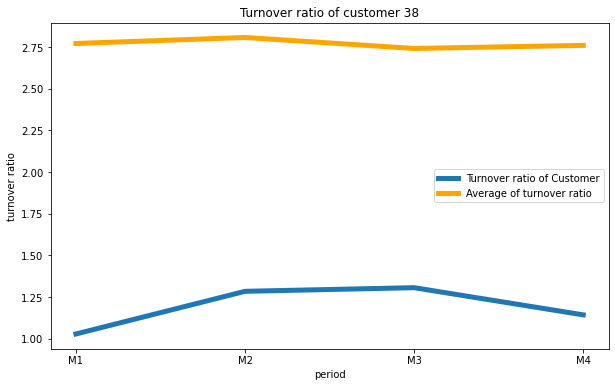

<ipython-input-58-1d44b4f2b7bc>:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_data = service_data.groupby('LABEL')['Return_M2', 'Return_M3', 'Return_M4'].agg('mean')


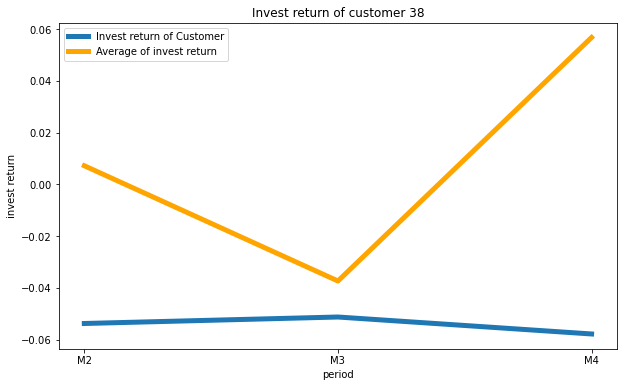

<ipython-input-58-1d44b4f2b7bc>:60: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_data = final_lottery_rate.groupby('LABEL')['M1', 'M2', 'M3', 'M4'].agg('mean')


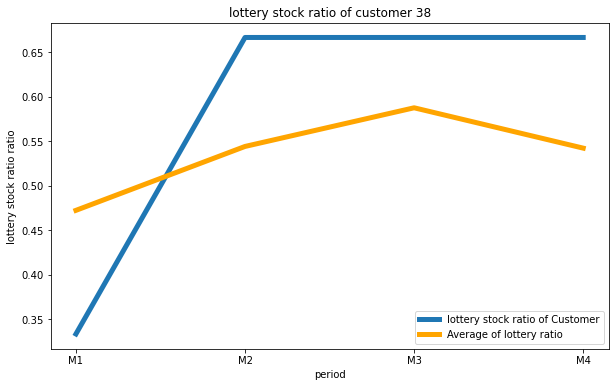

In [ ]:
#### graph 함수에 개인 고유 번호를 넣어주면 거래회전율, 투자 수익률, 복권성향 주식 보유 비중에 대한 그래프가 도출됨 

graph(38)